In [1144]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import random
from sklearn.cluster import KMeans
import numpy as np
from dataclasses import dataclass
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from lib.cf_a.cfae import CF_Ascent
from lib.eval.generator import run 
import pandas as pd
from lib.threshold_tree import ThresholdTree
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from lib.baycon import execute
from lib.ext.baycon.common.Target import Target

import matplotlib.pyplot as plt
import math

%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assignment Test
to see whether cluser changes make counterfactuals invalid

In [1145]:
random_state = 22
cf_amount = 20
nc = 2
#X, true_y = load_iris(return_X_y=True)

X, true_y = make_blobs(centers=nc, cluster_std=30, n_features=2, n_samples=32)

X = StandardScaler().fit_transform(X)

random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

In [1146]:
cfs_final = []
method_name = "cfae" # "cfae" or "dice_mod"

match method_name:
    case "cfae":
        amount = 10
        print('starting cfae')
        for cf in cfs:
            temp_cfs = []
            for i in range(amount):
                print('it: ' + str(i))
                x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=80, center_mode=False)
                temp_cfs.append(cf2)
            cfs_final.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))
    case "dice_mod":
        for cf in cfs:
            instance = X[cf.instance].reshape(1, -1)
            gainer = Gainer(centers, X, cf.target, instance, eps=0)
            dice_cf = np.array([
                # random_opt(instance, gainer.gain)[0][0] 
                adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
            for _ in range(1)])
            cfs_final.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))
    case "tt":
        for cf in cfs:
            tt = ThresholdTree(km, centers, X, y)
            tt_cf, tt_cf_prime = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
            cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
            cfs_final.append(cf_data)
    case "necs":
        for cf in cfs:
            i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
            cfs_final.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))
    case "baycon":
        baycon_cfs = []
        modes = ['kmeans', 'model_agnostic']
        run_mode = modes[1]

        pred = km.predict(X)
        pred = [str(l) for l in pred]
        stacked = np.column_stack((X, pred))
        df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
        df

        baycon_cfs = []
        for cf in cfs:
            point_idx = cf.instance
            point_pred = int(km.predict([X[point_idx]])[0])
            if run_mode == modes[0]:
                t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
            elif run_mode == modes[1]:
                t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

            baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
            cfs_final.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

starting cfae
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it

In [1147]:
from lib.eval.eval_metrics import cf_validity, cf_counterfactual_invalidation

average_validity_before = 0.0
average_validity_after = 0.0
kmeans_list = []
fails = []
for i,cf_final in enumerate(cfs_final):

    val_before_array = cf_validity(np.array(cf_final.cf),cf_final.target, centers)
    val_before = float(np.sum(val_before_array))/float(len(val_before_array))
    average_validity_before += val_before

    result, kmeans_new = cf_counterfactual_invalidation(cf=np.array(cf_final.cf), X=X, instance=cf_final.instance, centers=centers, target=cf_final.target, random_state=42, return_kmeans=True)
    val = np.sum(result) / float(len(result))
    average_validity_after += val

    for z, val_before_entry in enumerate(val_before_array):
        if val_before_entry != result[z]:
            fails.append((i, z))

    kmeans_list.append(kmeans_new)

print("Validty before change: ",average_validity_before / float(len(cfs_final)))
print("Validty after change: ",average_validity_after / float(len(cfs_final)))

Validty before change:  1.0
Validty after change:  0.95


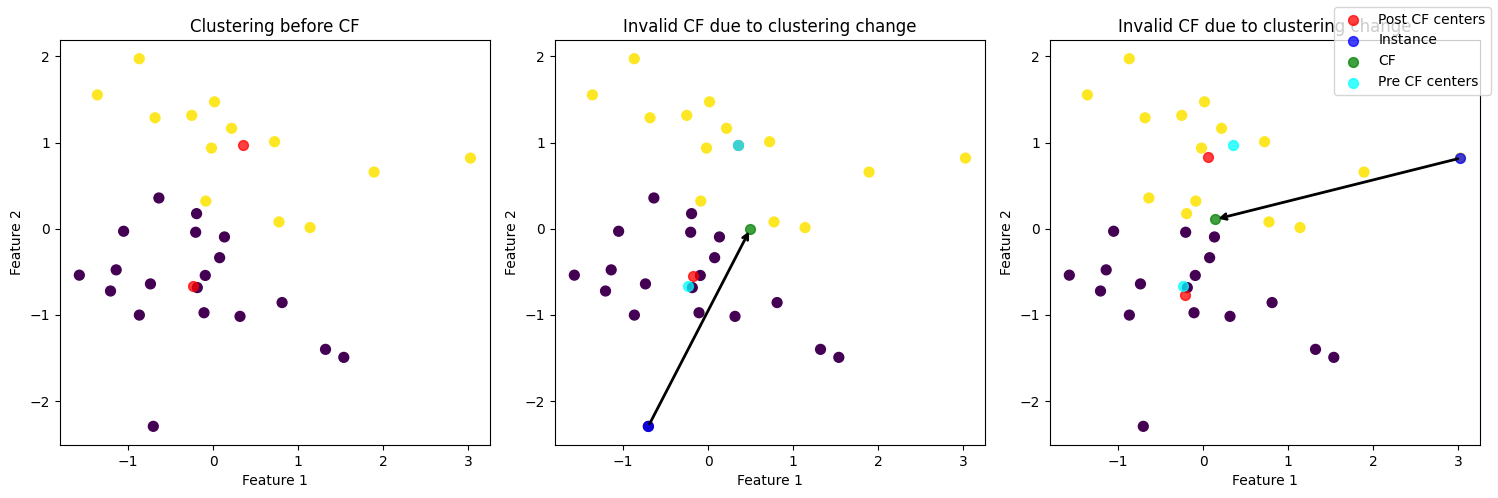

In [1148]:


seen_instances = []

# Calculate total number of plots (1 for the 'before CF' + 1 for each unique instance)
unique_instances = []
for fail in fails:
    i = fail[0]
    if cfs_final[i].instance not in unique_instances:
        unique_instances.append(cfs_final[i].instance)

total_plots = 1 + len(unique_instances)  # 1 for 'before CF'

cols = 3  # Customize as needed
rows = math.ceil(total_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# --- First plot: Clustering before CF ---
some_kmeans = kmeans_list[1][0]
y_plot = some_kmeans.predict(X)
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
axes[0].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='red', s=50, alpha=0.75)
axes[0].set_title("Clustering before CF")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

plot_idx = 1  # Start filling from the second subplot

# --- Remaining plots: Clustering after CF ---
for fail in fails:
    i = fail[0]
    z = fail[1]
    some_kmeans = kmeans_list[i][z]
    y_plot = some_kmeans.predict(X)
    instance = X[cfs_final[i].instance]
    target = cfs_final[i].target
    cf = cfs_final[i].cf[z]

    if cfs_final[i].instance in seen_instances:
        continue
    seen_instances.append(cfs_final[i].instance)

    ax = axes[plot_idx]
    plot_idx += 1

    ax.scatter(X[:, 0], X[:, 1], c=y_plot, s=50, cmap='viridis')
    ax.scatter(some_kmeans.cluster_centers_[:, 0], some_kmeans.cluster_centers_[:, 1],
               c='red', s=50, alpha=0.75, label='Post CF centers')
    ax.scatter(instance[0], instance[1], c='blue', s=50, alpha=0.75, label='Instance')
    ax.scatter(cf[0], cf[1], c='green', s=50, alpha=0.75, label='CF')
    ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
               c='cyan', s=50, alpha=0.75, label='Pre CF centers')
    ax.annotate('', xy=cf, xytext=instance,
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax.set_title(f"Invalid CF due to clustering change")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

# Optional: show legend in first or a custom location
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()
